In [131]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [132]:
mnist_data = torchvision.datasets.MNIST("../data", transform=T.ToTensor())
data = [x[0] for x in mnist_data]
labels = [x[1] for x in mnist_data]

data_np = np.array(data)
labels_np = np.array(labels)
data_np.shape, labels_np.shape

((60000, 1, 28, 28), (60000,))

In [133]:
mnist_test_data = torchvision.datasets.MNIST("../data", transform=T.ToTensor(), train=False)
test_data = [x[0] for x in mnist_test_data]
test_labels = [x[1] for x in mnist_test_data]

test_data_np = np.array(test_data)
test_labels_np = np.array(test_labels)
test_data_np.shape, test_labels_np.shape

((10000, 1, 28, 28), (10000,))

In [134]:
train_data_t = torch.Tensor(data_np).float()
train_labels_t = torch.Tensor(labels_np).long()
test_data_t = torch.Tensor(test_data_np).float()
test_labels_t = torch.Tensor(test_labels_np).long()

train_ds = TensorDataset(train_data_t, train_labels_t)
test_ds = TensorDataset(test_data_t, test_labels_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

In [138]:
def create_mnist_cnn(toggle_print):
    class MnistConvNet(nn.Module):
        def __init__(self, toggle_print: bool):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 10, 5, 1, 1) # 26
            self.pool1 = nn.MaxPool2d(2, 2) # 13
            self.conv2 = nn.Conv2d(10, 20, 5, 1, 1) # 11
            self.pool2 = nn.MaxPool2d(2, 2) # 5
            expected_size = np.floor((5 + 2*0 - 1)/1) + 1 # fc1 has no padding or kernel
            expected_size = 20*int(expected_size**2)
            self.fc1 = nn.Linear(expected_size, 50)
            self.out = nn.Linear(50, 10)
            self.toggle_print = toggle_print

        def forward(self, x):
            if self.toggle_print: print(f"Input shape: {x.shape}")
            x = torch.relu(self.pool1(self.conv1(x)))
            if self.toggle_print: print(f"After Conv Block 1: {x.shape}")
            x = torch.relu(self.pool2(self.conv2(x)))
            if self.toggle_print: print(f"After Conv Block 2: {x.shape}")
            x = x.reshape((x.shape[0], -1))
            if self.toggle_print: print(f"Vectorized cnn feat: {x.shape}")
            x = torch.relu(self.fc1(x))
            if self.toggle_print: print(f"After FC 1: {x.shape}")
            x = self.out(x)
            if self.toggle_print: print(f"After Out: {x.shape}")
            return x
        
    net = MnistConvNet(toggle_print=False)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [141]:
x = train_data_t[:5,:,:,:]
y = test_labels_t[:5]
print(x.shape, y.shape)
net, lossfunc, _ = create_mnist_cnn(False)
print(net)
yo = net(x)
print(f"{y.shape=}")
loss = lossfunc(yo, y)
print(f"{loss=}")
print(f"{yo=}")
print(torch.argmax(yo, axis=1))

torch.Size([5, 1, 28, 28]) torch.Size([5])
MnistConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=500, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)
y.shape=torch.Size([5])
loss=tensor(2.2891, grad_fn=<NllLossBackward0>)
yo=tensor([[ 0.0448,  0.1220, -0.0311, -0.0761,  0.0891, -0.0210, -0.0293, -0.1175,
         -0.0171,  0.0518],
        [ 0.0190,  0.1357, -0.0352, -0.0723,  0.0864, -0.0244, -0.0513, -0.1331,
          0.0153,  0.0407],
        [ 0.0364,  0.0917, -0.0468, -0.0663,  0.1156, -0.0039, -0.0570, -0.1036,
         -0.0096,  0.0608],
        [ 0.0431,  0.1096, -0.0437, -0.0613,  0.0948, -0.0112, -0.0504, -0.1065,
          0.

In [118]:
summary(net, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           5,020
         MaxPool2d-4             [-1, 20, 5, 5]               0
            Linear-5                   [-1, 50]          25,050
            Linear-6                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.12
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


In [147]:
def train_model(net: nn.Module, lossfunc, optimizer):
    epochs = 10
    train_acc = []
    test_acc = []
    losses = []
    
    for ei in range(epochs):
        net.train()
        batch_acc = []
        batch_losses = []
        for x, y in train_loader:
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1)==y).float()).item()
            batch_acc.append(acc)
            batch_losses.append(loss.detach())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_losses))

        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            y_test = net(x)
            test_acc.append(100*torch.mean((torch.argmax(y_test, axis=1)==y).float()).item())
        print(f"{ei=}, {losses[-1]=} {test_acc[-1]=}")

    return train_acc, test_acc, losses, net
            

In [148]:
train_acc, test_acc, losses, net = train_model(*create_mnist_cnn(False))

ei=0, losses[-1]=0.20943846 test_acc[-1]=97.85000085830688
ei=1, losses[-1]=0.063489616 test_acc[-1]=98.55999946594238
ei=2, losses[-1]=0.046104964 test_acc[-1]=98.58999848365784
ei=3, losses[-1]=0.03692049 test_acc[-1]=98.84999990463257
ei=4, losses[-1]=0.028770585 test_acc[-1]=98.83999824523926
ei=5, losses[-1]=0.02438484 test_acc[-1]=98.53000044822693
ei=6, losses[-1]=0.020682251 test_acc[-1]=98.91999959945679
ei=7, losses[-1]=0.017398654 test_acc[-1]=98.8099992275238
ei=8, losses[-1]=0.015219043 test_acc[-1]=98.86000156402588
ei=9, losses[-1]=0.013438107 test_acc[-1]=98.94999861717224


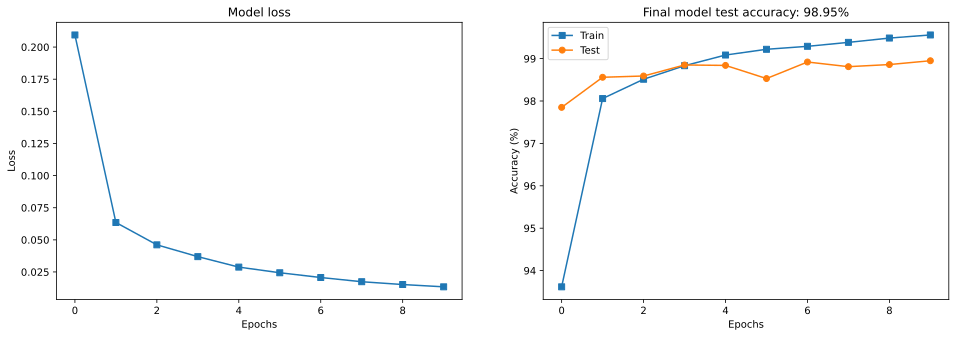

In [149]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(train_acc,'s-',label='Train')
ax[1].plot(test_acc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {test_acc[-1]:.2f}%')
ax[1].legend()

plt.show()

## From Instructor Notebook

In [124]:
import torch.nn.functional as F

In [123]:
# create a class for the model
def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,10,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (28+2*1-5)/1 )+1 = 26/2 = 13 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(10,20,kernel_size=5,stride=1,padding=1)
      # size: np.floor( (13+2*1-5)/1 )+1 = 11/2 = 5 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (5+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 20*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,50)

      ### output layer
      self.out = nn.Linear(50,10)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1/pool1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2/pool2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = mnistNet(printtoggle)

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [125]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorize: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
torch.Size([32, 10])
torch.Size([32])
 
Loss:
tensor(2.3277, grad_fn=<NllLossBackward0>)


In [126]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [127]:
trainAcc,testAcc,losses,net = function2trainTheModel()

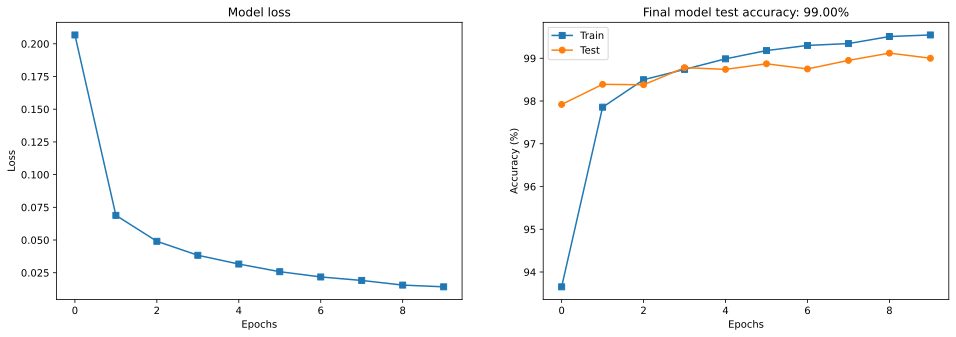

In [128]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()